In [10]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt

In [11]:
# set (local) path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/ampaim/'
mpath = '/tmp/sshfs/ampaim/'

In [12]:
# global functions
def rename_df(df, col):
    pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SS'),('healthy','Healthy')]
    for p in pairs:
        df[col] = df[col].replace(p[0],p[1])
    return df

In [13]:
###
# Load AB mapping file
###

# get AMPAIM+EISER mapping file w metadata; drop row 1
df_map_AB = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/Qiime2_0/qiime_mapping_file.tsv', sep='\t', header=0, index_col=0)

# get first row for any future operations
first_row = df_map_AB.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map_AB = df_map_AB.iloc[1:,]


###
# Specific replacements
###

# 526-0-twin-psaplate308 is missing a dash
df_map_AB = df_map_AB.rename(index={'526-0-twin-psaplate308': '526-0-twin-psa-plate308'})

###
# General replacements
###

# refrain from dropping NA's because you might need the columns for Q2 and you need to smoothly concat the first row

# convert index to str from float etc.
df_map_AB.index = df_map_AB.index.map(str)

# switch EISER diagnosis to eiser from NA
df_map_AB.loc[df_map_AB['Project'] == 'eiser', 'Diagnosis'] = 'eiser'

# RBB mapping file doesn't have info on duplicate controls, and the glass control info is extracted only from a subset of the names
# so we need to grab that info from AB's mapping file
samp_to_ctrlstatus = df_map_AB['Project'].to_dict()

# grab AB non-microteach samples
df_map_AB_filt = df_map_AB[df_map_AB['Project'].isin(['eiser','TWIN_PSA','glass_control','neg_control','duplicate_control'])]

df_map_AB_filt.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
116783-plate305,CCTCGCATGACC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116783,NaN,NaN,fecal,NaN,NaN,NaN
116784-plate305,CGCGCAAGTATT,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116784,NaN,NaN,fecal,NaN,NaN,NaN
116785-plate305,AAGGCGCTCCTT,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116785,NaN,NaN,fecal,NaN,NaN,NaN
116786-plate305,CGCAATGAGGGA,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116786,NaN,NaN,fecal,NaN,NaN,NaN
116787-plate305,ACGGCGTTATGT,CCGGACTACHVGGGTWTCTAAT,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116787,NaN,NaN,fecal,NaN,NaN,NaN


In [14]:
###
# Prepare for merge with RB mapping file
###

# load RB mapping file
df_map_RB = pd.read_csv(path + 'inputs/qiime_mapping_file_final_062123_RBB_ESR_CRPmod.csv', index_col=0)

# skip row with q2types; 140 columns
df_map_RB = df_map_RB.iloc[1:,]

# exclude unaffected since we are using TWINS_PSA from AB and controls from AB
# we only want microteach samples
df_map_RB = df_map_RB[df_map_RB['Diagnosis'].isin(['healthy','ss','sle','cd','RA','psa','pso'])]

# drop duplicate samples that appear in AB and that are controls per AB mapping file
for s in list(df_map_RB.index.values):
    if samp_to_ctrlstatus[s] in ['glass_control','duplicate_control','neg_control']:
        df_map_RB = df_map_RB.drop(s)
        
        
# merge with AB
df_meta = pd.concat([df_map_AB_filt, df_map_RB], axis=0)

# drop 'Separate' and 'Together'; presumably Q2 artifacts
df_meta = df_meta.drop(['Separate','Together'], axis=1)

# add in Project col from AB that describes controls
df_meta['Project'] = df_meta.index.map(samp_to_ctrlstatus)

###
# Specific replacements
###

# replace HxOtherDMARDs
df_meta.loc['540-0-twin-psa-plate308','HxOtherDMARDs'] = 'N'

### 
# General replacements
###

# specify float cols for later
float_cols = ['Age','BSA','CRP','DAS28','ESR','PhysicianGlobalPsA','RAPID3','SJC','TJC']

# Replace Y,N with 1,0 
df_meta = df_meta.replace({'Y':1,'N':0})

### 
# Create new mapping files
### 

def export_q2(df, first_row_df):
    df_q2 = df.reset_index()
    df_q2 = pd.concat([first_row_df, df_q2])
    df_q2 = df_q2.set_index('#SampleID')
    df_q2.loc['#q2:types',:] = 'categorical'
    df_q2 = df_q2.reset_index()
    return df_q2

# (1) filter out controls
df_meta = df_meta[df_meta['Project'].isin(['eiser','microteach','TWIN_PSA'])]

# (2) filter out treatments
# drop TWIN PSA and PSO samples that have treatment on biologics, DMARDS, MTX
drop_samples = ['275-psa-plate307', '475-psa-plate307', '542-0-twin-psa-plate308']
df_meta = df_meta.drop(drop_samples)

# remove samples that are treated other than above
drops = []
for v in ['CurrentBiologics', 'CurrentOtherDMARDs', 'CurrentMTX', 'HxOtherDMARDs']:
    df = df_meta[df_meta[v].isin(['Y',1])]
    drops = drops + list(df.index.values)

df_meta = df_meta.drop(drops)
print('Dropped this many samples: ' + str(len(drops)))

# drop eiser samples from downstream analysis
df_meta = df_meta[df_meta['Diagnosis'] != 'eiser']

# drop CD 
df_meta = df_meta[df_meta['Diagnosis'] != 'cd']

# drop unaffected twins
df_meta = df_meta[df_meta['Diagnosis'] != 'unaffected']

# export to Q2
df_meta_q2 = export_q2(df_meta, first_row_df)
df_meta_q2.to_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser_nocd.tsv', sep='\t', index=False, na_rep='nan') 



###
# Pre-processing
###

df_meta['Diagnosis'].value_counts()

Dropped this many samples: 18


Diagnosis
RA         41
psa        27
pso        25
healthy     6
ss          5
sle         4
Name: count, dtype: int64

In [15]:
# merge CDP and MSQ141 MMEDs qiime mapping files
# load CDP
df_cdp = pd.read_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser_nocd.tsv', sep='\t')
df_cdp['Batch'] = 'CDP'

# load MSQ141
df_141 = pd.read_csv(path + 'inputs/qiime_mapping_file_MSQ141.tsv', sep='\t')

# drop row 0 (#q2types) prior to merge
df_141 = df_141.iloc[1:,:]
df_141['Batch'] = 'MSQ141'

# add in diagnosis column that is IllnessNotes to all lowercase
df_141['Diagnosis'] = df_141['IllnessNotes'].apply(lambda x: x.lower())

# replace sjd with ss and psa_pso with psa
df_141['Diagnosis'] = df_141['Diagnosis'].replace('sjd','ss')
df_141['Diagnosis'] = df_141['Diagnosis'].replace('psa_pso','psa')
df_141['Diagnosis'] = df_141['Diagnosis'].replace('ra','RA')

# export
df_141_q2 = export_q2(df_141, first_row_df)
df_141_q2.to_csv(path + 'inputs/qiime_mapping_file_MSQ141_fixdiag.tsv', sep='\t', index=False, na_rep='nan') 

# merge rows
df_merge = pd.concat([df_cdp, df_141])#, axis=1)
df_merge = df_merge.set_index('#SampleID')
df_merge.loc['#q2:types',:] = 'categorical'

# note that lots of reasons might exist for batch effect, like treatment, also different diseases
# columns are not consistent (e.g. IllnessNotes in MSQ141 vs Diagnosis in CDP)
df_merge.to_csv(path + 'inputs/qiime_mapping_file_batch_nocd.tsv', sep='\t')

# standard binarize column for each medication
# convert from float
df_merge['Medication'] = df_merge['Medication'].astype(str)


# grab all medications
meds = list(df_merge['Medication'].values)

# drop 'categorical'
meds.remove('categorical')

uniq_meds = []
# split items with '_'
for m in meds:
    if '_' in m:
        items = m.split('_')
        items = [i.lower() for i in items]
        uniq_meds = uniq_meds + items
    else:
        uniq_meds.append(m.lower())
    
uniq_meds = list(set(list(uniq_meds)))
print(uniq_meds)

# create new column for each med
for u in uniq_meds:
    df_merge[u] = 0
    df_merge.loc[0,u] = 'categorical'

# iterate through each sample
for index, row in df_merge.iterrows():
    if index != 0: # the whole '#q2:types', 'categorical' thing
        medications = df_merge.loc[index,'Medication'].lower()
        medications = medications.split('_')
        for m in medications:    
            df_merge.loc[index,m] = 1

# new mapping file with med columns
df_merge = df_merge.drop(0)

# create involvement
def classify_psa(type):
    if type == 'peripheral':
        return 'peripheral'
    elif type == 'mixed' or type == 'axial': 
        return 'axial'
    else:
        return np.nan

df_merge['Involvement'] = df_merge['PsAtype'].apply(lambda x: classify_psa(x))

# create dict mapping diagnosis to samples
diag_to_samp = {}
for d in list(set(df_meta['Diagnosis'].values)):
    diag_to_samp[d] = list(df_meta[df_meta['Diagnosis'] == d].index.values)


# create copy df meta for nss and ss
df_meta = df_merge.copy()
df_meta = df_meta.drop('#q2:types')

# create df_merge that is a holder prior to filtering
df_merge_q2 = df_merge.copy()
df_merge_q2.loc['#q2:types',:] = 'categorical'
df_merge_q2 = df_merge_q2[df_merge_q2['Diagnosis'].isin(['non-sjogrens sicca','ss','categorical'])]
df_merge_q2['Diagnosis'] = df_merge_q2['Diagnosis'].replace('non-sjogrens sicca','nss')
df_merge_q2 = df_merge_q2.reset_index()
df_merge_q2.to_csv(path + 'inputs/qiime_mapping_file_merge_nss_ss.tsv', sep='\t', index=False, na_rep='nan')

# create copy df meta
df_merge_q2.loc['#q2:types',:] = 'categorical'
df_merge_q2.to_csv(path + 'inputs/qiime_mapping_file_merge_meds.tsv', sep='\t', index=False, na_rep='nan')

df_merge_q2.head()

['topicals', 'prednisone', 'hcq', 'mtx', 'nomed', 'nan', 'leflunomide']


,#SampleID,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,...,AgeAtVisit,topicals,prednisone,hcq,mtx,nomed,nan,leflunomide,categorical,Involvement
0,#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
1,769-slesjo-plate308,CGGGACACCCGA,CCGGACTACHVGGGTWTCTAAT,C2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN
2,2771-slesjo-plate308,ACCTTACACCTT,CCGGACTACHVGGGTWTCTAAT,D2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN
3,2948-slesjo-plate308,GTAGTAGACCAT,CCGGACTACHVGGGTWTCTAAT,E2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN
4,131-slesjo-plate308,CCGGACAAGAAG,CCGGACTACHVGGGTWTCTAAT,F2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN


In [16]:
# disease breakdown by sample numbers
df_141_q2['IllnessNotes'].value_counts()

IllnessNotes
Non-Sjogrens sicca    12
SjD                    5
PsO                    3
RA                     2
categorical            1
SLE                    1
PsA_PsO                1
Name: count, dtype: int64

KruskalResult(statistic=0.0173913043478251, pvalue=0.8950822971464321)


Diagnosis
NSS    12
SS     10
Name: count, dtype: int64

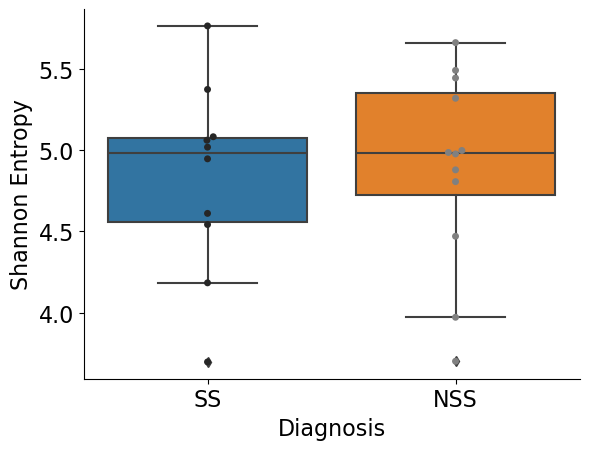

In [17]:
# plot nicer alpha div
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# convert NSS to SICCA
pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SS'),('healthy','Healthy')]     
for p in pairs:
    df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace(p[0],p[1])
    
# subset on NSS SS
df_alpha = df_alpha[df_alpha['Diagnosis'].isin(['NSS','SS'])]

# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Diagnosis",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.Diagnosis.value_counts()


KruskalResult(statistic=0.2727272727272805, pvalue=0.6015081344405846)


Diagnosis
RA                    43
pso                   28
psa                   28
non-sjogrens sicca    12
ss                    10
healthy                6
sle                    5
Name: count, dtype: int64

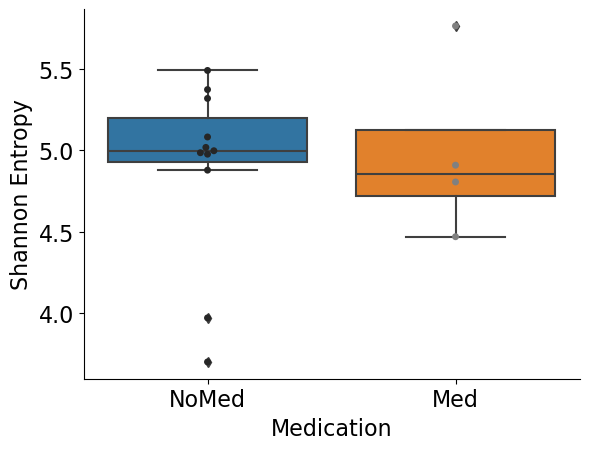

In [18]:
# plot medication alpha div
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# create new column based off of Medication column
df_med = df_alpha.copy()

# subset based on relevant meds
df_med = df_med[df_med['Medication'].isin(['NoMed','HCQ_prednisone','MTX','MTX_HCQ','Prednisone_MTX_Leflunomide'])] 

for m in ['HCQ', 'MTX', 'NoMed']:
    df_med[m] = df_med['Medication'].apply(lambda x: 1 if m in x else 0)

# convert medication into binary
df_med['Medication'] = df_med['Medication'].apply(lambda x: 'NoMed' if x == 'NoMed' else 'Med')

# export for R
df_med.to_csv(path + 'inputs/df_med.tsv', sep='\t')

# KW test
print(scipy.stats.kruskal(*list(df_med.groupby('Medication')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_med, x='Medication', y='shannon_entropy')
sns.swarmplot(data=df_med, x='Medication', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Medication",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.Diagnosis.value_counts()


In [19]:
df_alpha.Medication.value_counts()

Medication
NoMed                         11
HCQ                            4
Topicals                       3
HCQ_prednisone                 1
MTX                            1
MTX_HCQ                        1
prednisone                     1
Prednisone_MTX_Leflunomide     1
Topicals_prednisone            1
Name: count, dtype: int64

KruskalResult(statistic=12.0904820568486, pvalue=0.05998043490265998)


Diagnosis
RA         43
PsO        28
PsA        28
NSS        12
SS         10
Healthy     6
SLE         5
Name: count, dtype: int64

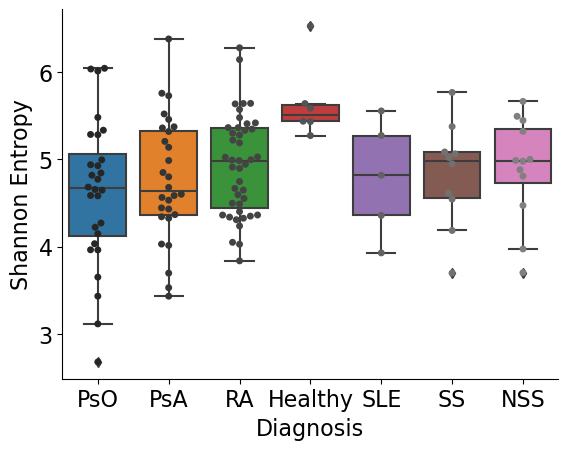

In [20]:
# plot nicer alpha div
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# convert NSS to SICCA

# rename
pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SS'),('healthy','Healthy')]     
for p in pairs:
    df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace(p[0],p[1])


# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Diagnosis",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.to_csv(path + 'outputs/jobs27/df_alpha.tsv', sep='\t')
df_alpha.Diagnosis.value_counts()


In [21]:
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
df_pc = df_pc.set_index('131-slesjo-plate308') 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['131-slesjo-plate308'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_meta], axis=1)

# rename
pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SS'),('healthy','Healthy')]
for p in pairs:
    df_pc['Diagnosis'] = df_pc['Diagnosis'].replace(p[0],p[1])

df_pc.to_csv(path + 'outputs/jobs27/unweighted_pcoa.tsv', sep='\t')
df_pc.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,AgeAtVisit,topicals,prednisone,hcq,mtx,nomed,nan,leflunomide,categorical,Involvement
209-pso-plate307,0.062894,-0.047001,-0.003304,-0.055587,0.08124,0.070976,0.00132,-0.050877,-0.013162,-0.023986,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN
235-psa-plate307,0.092096,-0.074027,-0.004846,0.089962,-0.072339,-0.085908,-0.053861,-0.11416,0.04784,0.091376,...,NaN,0.0,0,0,0,0,1,0,NaN,peripheral
240-psa-plate307,0.124884,-0.057131,-0.014148,-0.085413,-0.020368,-0.001142,-0.072633,-0.106414,-0.005917,0.039714,...,NaN,0.0,0,0,0,0,1,0,NaN,axial
241-pso-plate307,-0.07952,0.003158,0.152208,0.134782,0.077693,0.019814,0.059889,-0.018681,0.001654,-0.058065,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN
260-pso-plate307,-0.022745,0.235147,-0.103778,-0.030971,0.091113,-0.037331,-0.116086,-0.030346,-0.055308,0.047916,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN


In [22]:
### Loop for all LEfSe
# for LEfSe, jobs00, aggregate
# pairs, [<list of group 1> <list of group 2>]
### Loop for all LEfSe
# for LEfSe, jobs00, aggregate
# pairs, [<list of group 1> <list of group 2> <aggregate group 2>]
comp_to_groups = {
    'AvH': (['healthy'],['psa','pso','ss','cd','sle','RA', 'non-sjogrens sicca'],['affected']), # healthy vs disease aggregate, jobs03
    'RAvH': (['healthy'],['RA'],['RA']), # jobs04 
    'PsOvH': (['healthy'],['pso','pso'],['PsA']), #jobs05
    'PsAvH': (['healthy'],['psa','psa'],['PsA']), #jobs05
    'SSvH': (['healthy'],['ss'],['ss']), #jobs06
    'SICCAvH': (['healthy'],['non-sjogrens sicca'],['non-sjogrens sicca']), #jobs06
    'SLEvH': (['healthy'],['sle'],['sle'])
}

for c in comp_to_groups:
    # unpack tuples
    healthy, disease, aggregate = comp_to_groups[c]
    
    # subset relevant diseases
    df_meta_XvH = df_merge[df_merge['Diagnosis'].isin(healthy + disease)]
    
    # change all diseases to aggregate string
    df_meta_XvH.loc[df_meta_XvH['Diagnosis'].isin(disease), 'Diagnosis'] = aggregate[0]

    # add first row
    df_meta_XvH = df_meta_XvH.reset_index()
    df_meta_XvH = pd.concat([first_row_df, df_meta_XvH])
    df_meta_XvH = df_meta_XvH.set_index('#SampleID')
    df_meta_XvH.loc["#q2:types",:] = 'categorical' 

    # export to csv
    df_meta_XvH.to_csv(path + 'inputs/qiime_mapping_file_merge_' + c + '.tsv', sep='\t', na_rep='nan')
    df_meta_XvH.head()

df_meta_XvH.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,AgeAtVisit,topicals,prednisone,hcq,mtx,nomed,nan,leflunomide,categorical,Involvement
#SampleID,,,,,,,,,,,,,,,,,,,,,
#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
SCFA08-B-plate308,AGCCTTCGTCGC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN
MicraHC-1017-B-plate308,CGTATAAATGCG,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN
MicraHC-1018-B-plate308,TGACTAATGGCC,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN
MicraHC-1019-B-plate308,GTGGAGTCTCAT,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0,0,0,0,1,0,NaN,NaN


In [50]:
# unnormalized OTU table level-6 also has metadata in it! nice 
# from taxa_bar_plot.qzv
L_to_otu = {}
levels = [6,7]
L_to_spec_otu = {}
# build dict of otu tables
for l in levels:
    # construct key
    level = 'L' + str(l)

    # read in df otu
    df_otu = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/level-' + str(l) + '.csv', index_col=0)
    
    # determine columns to drop; i.e. keep taxa only
    dropcol = []
    for c in list(df_otu.columns.values):
        if c[0:3] != 'd__':
            dropcol.append(c)
            
    # keep Diagnosis for later
    keepcol = df_otu['Diagnosis']
    
    df_otu = df_otu.drop(dropcol, axis=1)
    df_otu.to_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/counts_L' + str(l) + '.csv')
    
    # normalize the cols
    df_otu = df_otu.div(df_otu.sum(axis=1), axis=0)
    df_otu.to_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/otu_table_L' + str(l) + '.csv')

    # take taxa of interest
    # d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A
    # d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125
    # d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri
    taxa = {}
    taxa['L6'] = ['d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A',
                  'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125',
                  'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Coprobacteraceae;g__Coprobacter']
    taxa['L7'] = ['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri']
    renamed = {}
    renamed['L6'] = ['Phascolarctobacterium_A', 'Anaerotignum_189125', 'Coprobacter']
    renamed['L7'] = ['Prevotella_copri']
    
    df_otu_spec = df_otu.loc[:,taxa['L' + str(l)]]
    df_otu_spec.columns = renamed['L' + str(l)]
    
    # reappend dx
    df_otu = pd.concat([df_otu, df_meta.loc[:,['BSA','CRP','ESR','SJC','TJC','Diagnosis']]],axis=1)
    df_otu = rename_df(df_otu, 'Diagnosis')
    df_otu.to_csv(path + 'inputs/otu_table_L' + str(l) + '_meta.csv')

    # add to dict 
    L_to_otu[level] = df_otu
    df_otu_spec = pd.concat([df_otu_spec, df_meta.loc[:,['BSA','CRP','ESR','SJC','TJC','Diagnosis']]],axis=1)
    df_otu_spec = rename_df(df_otu_spec, 'Diagnosis')
    L_to_spec_otu[level] = df_otu_spec

df = pd.concat([L_to_spec_otu['L6'].loc[:,renamed['L6']], L_to_spec_otu['L7']], axis=1)
df.to_csv(path + 'inputs/df_otu_meta.csv')
df.head()

,Phascolarctobacterium_A,Anaerotignum_189125,Coprobacter,Prevotella_copri,BSA,CRP,ESR,SJC,TJC,Diagnosis
131-slesjo-plate308,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,SS
209-pso-plate307,0.022813,0.000264,0.0,0.000000,3.0,NaN,10.0,0.0,2.0,PsO
235-psa-plate307,0.000000,0.004882,0.0,0.000000,3.0,NaN,NaN,0.0,1.0,PsA
240-psa-plate307,0.008384,0.000000,0.0,0.000000,13.0,NaN,NaN,0.0,7.0,PsA
241-pso-plate307,0.001458,0.000000,0.0,0.000039,7.0,NaN,NaN,0.0,0.0,PsO


In [24]:
for x in (L_to_otu['L7'].columns.values):
    if 'Anaerotignum' in x:
        print(x)
    if 'Phascolarctobacterium' in x:
        print(x)
    if 'copri' in x:
        print(x)

d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri
d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A;s__Phascolarctobacterium_A sp900545025
d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A;s__Phascolarctobacterium_A faecium
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125;__
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125;s__Anaerotignum lactatifermentans
d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A;__
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189163;s__Anaerotignum aminivorans


In [25]:
# First go to R and run the DMM script to generate the cluster assignments and scores
#df_dmm = pd.read_csv(path + 'outputs/visualizations_dir_nyu/dmm_lplc_relabd_assign.tsv', sep='\t', index_col=0)
# df_dmm = pd.read_csv(path + 'outputs/jobs19/dmm_lplc_relabd_assign.tsv', sep='\t', index_col=0)
# df_final = pd.concat([df_meta, df_dmm], axis=1)
# df_final.index.name = '#SampleID'

# export for rerun Q2
# df_disease = export_q2(df_final, first_row_df)
# df_disease.to_csv(path + 'inputs/qiime_mapping_file_psara_dmm.tsv', sep='\t', index=False, na_rep='nan')

# assess chi square GOF
# df_final = df_final.dropna(axis='rows', subset=['Diagnosis'])

df_final = pd.read_csv(path + 'inputs/qiime_mapping_file_psara_dmm.tsv', sep='\t')
df_final = df_final.iloc[1:,:]
df_final = df_final.dropna(axis='rows', subset=['Diagnosis'])

# new col for SJ TJC binary
df_final['TJCpos'] = df_final['TJC'].map(lambda x: 1 if float(x) > 0 else 0)
df_final['SJCpos'] = df_final['SJC'].map(lambda x: 1 if float(x) > 0 else 0)

# DMM GROUPING
dmm = [int(float(x)) for x in df_final['dmm.grp'].values]
diag = df_final['Diagnosis'].values

# disease_grouping only exists if we grouped RA and PsA etc.
for col in ['Diagnosis']: # ,'disease_grouping_1','disease_grouping_2']:
    diag = df_final[col].values
    for d in list(set(diag)):
        y = np.array([0 if x == d else 1 for x in diag])
        x,p = scipy.stats.chisquare(f_obs=[dmm, y], axis=None)#, f_exp=None, ddof=0, axis=0)
        #if p<0.05:
        print(col)
        print(d)
        print(p)
print('Done')


Diagnosis
pso
1.0
Diagnosis
ss
1.0
Diagnosis
sle
1.0
Diagnosis
RA
1.0
Diagnosis
healthy
1.0
Diagnosis
non-sjogrens sicca
1.0
Diagnosis
psa
1.0
Done


In [26]:
# combine LEfSe results
# all files are lefse_table.tsv
# add 10 for L7 results, L6 is listed below
'''
outputs/
	jobs11							# LEfSe for PsAvH
	jobs10							# LEfSe for PsOvH
    jobs16                          # AvH
    jobs09                          # RAvH
    jobs12                          # SSvH
    jobs13                          # SLEvH
    jobs15                          # SS+SLE aka SSSLEvH        
    jobs14                          # NSS
'''
# create dict mapping diagnosis to lefse results
# start w/ two disease for play testing
# eventually can consider the enriched in H set, but start with enriched in diseased set
diag_to_lefse = {}
diag_to_path = {}
diag_to_lefse_disease = {}
diag_to_lefse_healthy = {}
for l in ['L6', 'L7']:
    diag_to_lefse_disease[l] = {
        'PsA': [],
        'PsO': [],
        #'A': [],
        'RA': [],
        'SS': [],
        'SLE': [],
        # 'SSSLE': [],
        'NSS': [],
    }
    diag_to_lefse_healthy[l] = {
        'PsA': [],
        'PsO': [],
        #'A': [],
        'RA': [],
        'SS': [],
        'SLE': [],
        # 'SSSLE': [],
        'NSS': [],
    }

diag_to_path['L6'] ={
    'PsA': 'outputs/jobs11/',
    'PsO': 'outputs/jobs10/',
    #'A': 'outputs/jobs16/',
    'RA': 'outputs/jobs09/',
    'SS': 'outputs/jobs12/',
    'SLE': 'outputs/jobs13/',
    'NSS': 'outputs/jobs14/',
    # 'SSSLE': 'outputs/jobs15/',
}
diag_to_path['L7'] ={
    'PsA': 'outputs/jobs21/',
    'PsO': 'outputs/jobs20/',
    #'A': 'outputs/jobs26/',
    'RA': 'outputs/jobs19/',
    'SS': 'outputs/jobs22/',
    'SLE': 'outputs/jobs23/',
    'NSS': 'outputs/jobs24/',
    # 'SSSLE': 'outputs/jobs25/',
}

# counter dicts per level
L_to_count = {}
from collections import defaultdict

# '' is disease, otherwise healthy
for l in ['L6','L7']:
    L_to_count[l] = {}
    for h in ['healthy_','']:
        L_to_count[l][h] = defaultdict()
        
        # common to all
        print(h)
        for diag in diag_to_path[l]:        
            # import df, rename columns
            df_lefse = pd.read_csv(path + diag_to_path[l][diag] + 'lefse_results.res', sep='\t', header=None)    
            df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
            
            # replace dash with nan, cast to float
            df_lefse = df_lefse.replace('-', np.nan)
            df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
            
            # get sig results and results pertaining to enriched group
            df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
            if h == 'healthy_':
                df_lefse = df_lefse[df_lefse['Enriched_Group'] == 'healthy']
            else:
                df_lefse = df_lefse[df_lefse['Enriched_Group'] != 'healthy']
            
            # drop na
            df_lefse = df_lefse.dropna()
            
            print(diag)
            print(len(df_lefse))
            if h == '':
                print(df_lefse.Taxa.values)

            for taxa in df_lefse.Taxa.values:
                if taxa in L_to_count[l][h]:
                    L_to_count[l][h][taxa] += 1
                else:
                    L_to_count[l][h][taxa] = 1
                
            if diag == 'PsA':
                shared = set(df_lefse['Taxa'].values)
            else:
                shared = shared.intersection(set(df_lefse['Taxa'].values))
            
            #df_lefse = df_lefse.sort_values('Effect_Size')
            df_lefse.to_csv(path + 'outputs/jobs04/' + l + '_' + diag + '_lefse_' + h + 'sig.tsv', sep='\t')
            if h == 'healthy_':
                diag_to_lefse_healthy[l][diag] = list(df_lefse['Taxa'].values)
            else:            
                diag_to_lefse_disease[l][diag] = list(df_lefse['Taxa'].values)
    
        print(shared)
# convert to df for output file to R
# summary_df = pd.Dataframe()
# summary_df = pd.DataFrame.from_dict(diag_to_lefse)
# summary_df




healthy_
PsA
64
PsO
54
RA
39
SS
26
SLE
14
NSS
23
{'d__Bacteria.p__Firmicutes_C.c__Negativicutes.o__Acidaminococcales.f__Acidaminococcaceae.g__Phascolarctobacterium_A'}

PsA
1
['d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ']
PsO
1
['d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Oscillospirales.f__CAG_272.g__QALR01']
RA
1
['d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Prevotella']
SS
2
['d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Oscillospirales.f__Oscillospiraceae_88309.g__Lawsonibacter'
 'd__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Lachnospirales.f__Lachnospiraceae.g__Clostridium_Q_134516']
SLE
3
['d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ'
 'd__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Peptostreptococcales.f__Anaerovoracaceae.__'
 'd__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Lachnospirales.f__Lach

In [27]:
# query via UpSetR plot
# enter the set of interest ['PsA','PsO']
# PsA, PsO, RA, SS, SLE, NSS, then check against A
query = ['PsA', 'PsO']
query = ['PsA', 'PsO', 'RA','SLE','SS']
query = ['NSS', 'SLE', 'PsA']

sets = []
label = 'healthy' # 'affected'
label = 'affected'
level = 'L7'


for q in query:
    if label == 'healthy':
        sets.append(diag_to_lefse_healthy[level][q])
    else:
        sets.append(diag_to_lefse_disease[level][q])
print(set.intersection(*[set(x) for x in sets]))



{'d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ.s__Clostridium_AQinnocuum', 'd__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ'}


In [48]:
# taxa of interest
#pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri'
#pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae'
#pcopri = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Phascolarctobacterium'
#pcopri = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae'
#pcopri = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Oxalobacter'
#pcopri ='k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__luteciae'
#taxas = ['d__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;__',
#        'd__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__',
#        'd__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Phascolarctobacterium']

taxas = ['d__Bacteria.p__Firmicutes_C.c__Negativicutes.o__Acidaminococcales.f__Acidaminococcaceae.g__Phascolarctobacterium_A',
         'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Coprobacteraceae;g__Coprobacter',
         'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri']

taxa_sub = ['Phascolarctobacterium_A', 'Coprobacter', 'Prevotella_copri']

for t in range(len(taxas)):
    original = taxas[t].replace('.',';')
    taxa = original.split('__')[-1]
    print(taxa)
    
    if 'copri' in taxa:
        df_otu = L_to_otu['L7'].copy()
        df_otu_spec = df_otu[df_otu['Diagnosis'].isin(['RA','psa','healthy'])]

    if 'Phas' in taxa:
        df_otu_spec = L_to_otu['L6'].copy()

    if 'Coprobacter' in taxa:
        df_otu_spec = L_to_otu['L6'].copy()
        
    # replacements for figure formatting
    df_otu_spec = rename_df(df_otu_spec, 'Diagnosis')
    
    # KW test
    print(scipy.stats.kruskal(*list(df_otu_spec.groupby('Diagnosis')[original].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))
    
    # do sns 
    ax = sns.boxplot(data=df_otu_spec, x='Diagnosis', y=original)
    sns.swarmplot(data=df_otu_spec, x='Diagnosis', y=original, palette='dark:grey', hue=None)
    
    # formatting
    ax.set_ylabel(taxa,fontsize=16)
    ax.set_xlabel("Disease",fontsize=16)
    ax.tick_params(labelsize=16)
    sns.despine()
    plt.savefig(path + 'outputs/jobs00/' + taxa + '.pdf')
    plt.close()

    # export tsv
    df_otu_spec = df_otu_spec.rename(columns={original: taxa_sub[t]})
    df_otu_spec.loc[:,['Diagnosis',taxa_sub[t]]].to_csv(path + 'outputs/jobs27/' + taxa + '.tsv', sep='\t')



Phascolarctobacterium_A
KruskalResult(statistic=12.944717632463972, pvalue=0.043922283304510035)
Coprobacter
KruskalResult(statistic=13.022050140356686, pvalue=0.04268712225625253)
Prevotella copri


ValueError: Need at least two groups in stats.kruskal()

In [47]:
df = L_to_otu['L6']
for x in df.columns:
    if 'opro' in x:
        print(x)

d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus_A_187866
d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Catenibacterium
d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Faecalibacillus
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__Copromorpha
d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Fimiplasma
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Copromonas
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus_A_121497
d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__
d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus
d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__
d__Bacteria

In [ ]:
# across psa, ra do CRP DAS 28 etc
# metadata box plot with diagnosis
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
for q in qvars:
    df_meta[q] = df_meta[q].astype(float)
    df = df_meta[['Diagnosis',q]].dropna(how='any')
    df = rename_df(df, 'Diagnosis')
    df.index.name = 'SampleID'
    df.to_csv(path + 'inputs/' + 'df_meta_' + q + '.tsv', sep='\t')
    k,p = scipy.stats.kruskal(*list(df.groupby('Diagnosis')[q].apply(list).values), nan_policy='omit', axis=0, keepdims=False)
    print(q)
    print(k,p)

    
    # do sns 
    plt.figure(figsize=(3,2))
    ax = sns.boxplot(data=df, x='Diagnosis', y=q)
    sns.swarmplot(data=df, x='Diagnosis', y=q, palette='dark:grey', hue=None)

    # figure settings
    ax.set_ylabel(q,fontsize=12)
    ax.set_xlabel("Diagnosis",fontsize=12)
    ax.tick_params(labelsize=12)
    plt.title("{:.2e}".format(p),fontsize=12)
    plt.tight_layout()
    sns.despine()
    plt.savefig(path + 'outputs/jobs01/dx_meta/' + q + '.pdf')
    plt.close()

df.head()

In [29]:
# metadata correlation with adiv
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
dx = [['PsA'],['PsO'],['RA'],['PsA','PsO','RA']]
for q in qvars:
    df_meta[q] = df_meta[q].astype(float)

    # grab for PsA only, PsO only, RA only, and then combine all 3
    for d in dx:
        df = pd.concat([df_alpha[df_alpha['Diagnosis'].isin(d)]['shannon_entropy'], df_meta[q]],axis=1)
        r, p = scipy.stats.spearmanr(df['shannon_entropy'],df[q], nan_policy='omit')
        if p < 0.05:
            print(q, d, p)
                
        # do sns 
        ax = sns.lmplot(data=df, x='shannon_entropy', y=q)
        
        plt.title(str(d),fontsize=16)
        #ax.set_ylabel(q,fontsize=16)
        #ax.set_xlabel("Shannon Entropy",fontsize=16)
        #ax.tick_params(labelsize=16)
        plt.tight_layout()
        sns.despine()
        plt.savefig(path + 'outputs/jobs01/alpha_corr/' + q + '_' + str(d) + '_' + str(p)[0:5] + '.pdf')
        plt.close()



CRP ['PsO'] 0.0


In [30]:
# need a cutie job for
# each AMP AIM disease; actually only PsA PsO and RA and each subset have clinical metadata
# subset each mapping file on the disease of interest
# use the same L6, L7 table
# PsA ax vs periph

from itertools import chain, combinations

def subsets_iterative(lst):
    return list(chain.from_iterable(combinations(lst, r) for r in range(len(lst)+1)))

from pathlib import Path

dx = ['psa','pso','RA']
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
levels = ['L6', 'L7']

dx_sets = subsets_iterative(dx)[1:]

for d in dx_sets:
    # get string descriptor 
    diag = '_'.join(['{}']*len(d)).format(*d)
    
    for l in levels:
        # Specify the directory path
        wd = Path(path + 'outputs/jobs02/' + l + '_' + diag)

        # Create the directory recursively
        wd.mkdir(parents=True, exist_ok=True)

    # Create input mapping files
    df = df_meta[df_meta['Diagnosis'].isin(d)][qvars + ['Diagnosis','Involvement']]
    df = rename_df(df, 'Diagnosis')
    df.to_csv(path + 'inputs/df_meta_' + diag + '.tsv', sep='\t')

# L_to_otu['L6']
df.head()
# df_meta

,BSA,CRP,ESR,DAS28,TJC,SJC,Diagnosis,Involvement
#SampleID,,,,,,,,
518-0-twin-psa-plate308,1.5,NaN,NaN,NaN,2.0,0.0,PsO,NaN
524-0-twin-psa-plate308,4.0,NaN,NaN,NaN,0.0,0.0,PsO,NaN
525-0-twin-psa-plate308,2.0,NaN,NaN,NaN,1.0,0.0,PsO,NaN
528-0-twin-psa-plate308,3.5,NaN,NaN,NaN,0.0,0.0,PsO,NaN
529-0-twin-psa-plate308,0.0,NaN,NaN,NaN,0.0,0.0,PsO,NaN


In [31]:
# examine the LEfSe taxa and look in the CUTIE jobs for corr w differential taxa
'''
outputs/
	jobs11							# LEfSe for PsAvH
	jobs10							# PsOvH
    jobs09                          # RAvH
'''
# where LEfSe results are stored
diag_to_path = {}
diag_to_path['L6'] ={
    'psa': 'outputs/jobs11/',
    'pso': 'outputs/jobs10/',
    'RA': 'outputs/jobs09/'
}
diag_to_path['L7'] ={
    'psa': 'outputs/jobs21/',
    'pso': 'outputs/jobs20/',
    'RA': 'outputs/jobs19/'
}

levels = ['L6','L7']
for l in levels:
    print(l)
    for d in dx_sets:    
        dx = '_'.join(['{}']*len(d)).format(*d)
        print(dx)
        # grab cutie taxa
        df_qt = pd.read_csv(path + 'outputs/jobs02/' + l + '_' + dx + '/data_processing/summary_df_resample_1.txt', sep='\t')
    
        # get sig subset
        df_qt = df_qt[df_qt['class'].isin(['TP'])]#,'FP'])]
        cutie_taxa = df_qt['var2'].values
 
        # get all possible subsets
        for diag in dx.split('_'):
            # import df, rename columns
            df_lefse = pd.read_csv(path + diag_to_path[l][diag] + 'lefse_results.res', sep='\t', header=None)    
            df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
            
            # replace dash with nan, cast to float
            df_lefse = df_lefse.replace('-', np.nan)
            df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
            
            # get sig results and results pertaining to enriched group
            df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
            
            # drop na
            df_lefse = df_lefse.dropna()
        
            # diff taxa
            lefse_taxa = [x.replace('.',';') for x in list(df_lefse['Taxa'].values)]
        
            # check overlap
            taxa = set(cutie_taxa).intersection(set(lefse_taxa))
            print(len(taxa))
            print(diag,taxa)
            print([list(L_to_otu[l].columns.values).index(x) for x in taxa])
    
            # save overlap
            df_res = df_qt[df_qt['var1'].isin(taxa)]
            df_res.to_csv(path + 'outputs/jobs02/' + l + '_' + dx + '/' + diag + '_lefse.tsv', sep='\t')








L6
psa
3
psa {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__', 'd__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A', 'd__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;__'}
[145, 77, 90]
pso
2
pso {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Clostridium_Q_135822', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871404'}
[134, 196]
RA
1
RA {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125'}
[182]
psa_pso
2
psa {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__', 'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__UBA644;g__UBA644'}
[145, 72]
4
pso {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__UBA644;g__UBA6

In [32]:
# specific subgroup comparisons
# PsA axial versus peripheral
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_psa/metadata.tsv', sep='\t', index_col=0)
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha[['Involvement','shannon_entropy']]
df_alpha = rename_df(df_alpha, 'Involvement')
df_alpha.to_csv(path + 'outputs/jobs27/df_alpha_psa.tsv', sep='\t')

# beta div
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'inputs/Q2_MSQ138_141_psa/ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
df_pc = df_pc.set_index('235-psa-plate307') 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['235-psa-plate307'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_alpha], axis=1)
df_pc.to_csv(path + 'outputs/jobs27/bray_curtis_pcoa_psa.tsv', sep='\t')
df_pc.head()


# SS vs NSS
# alpha div
df_alpha = pd.read_csv(path + 'outputs/jobs08/nss_ss/metadata.tsv', sep='\t', index_col=0)
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha[['Diagnosis','shannon_entropy']]
df_alpha = rename_df(df_alpha, 'Diagnosis')
df_alpha.to_csv(path + 'outputs/jobs27/df_alpha_nss_ss.tsv', sep='\t')

# beta div
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'outputs/jobs08/nss_ss/ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
df_pc = df_pc.set_index('131-slesjo-plate308') 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['769-slesjo-plate308'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_alpha], axis=1)
df_pc.to_csv(path + 'outputs/jobs27/bray_curtis_pcoa_nss_ss.tsv', sep='\t')
df_pc.head()






,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,Diagnosis,shannon_entropy
2771-slesjo-plate308,-0.255212,0.392981,-0.011698,-0.216296,0.092152,0.08694,0.024876,-0.008833,-0.102979,0.187219,...,0.093451,0.001583,0.028687,-0.082593,0.105308,-0.050785,-0.01777,0.0,SS,4.68594755296148
2876-slesjo-plate308,-0.425417,-0.081195,0.119876,-0.200453,-0.138484,0.04692,0.046187,-0.053609,0.065852,-0.111238,...,-0.144975,0.10819,-0.099505,-0.068588,-0.03812,-0.090668,0.08427,0.0,SS,3.78721409544421
2948-slesjo-plate308,-0.382752,-0.29328,0.018855,0.032614,-0.005609,0.020488,0.068568,-0.001412,-0.05278,0.021443,...,0.003081,-0.113893,-0.096934,0.118116,0.111546,0.137141,-0.021743,0.0,SS,4.56281780634126
769-slesjo-plate308,0.16748809818237156,0.062430381751143016,0.27757572902508143,-0.04344858111566439,-0.25211083009420926,-0.09981261532325726,-0.03348358664034761,0.14991243212756492,0.084689563520878,-0.168534638401169,...,0.008411717018964983,-0.010888426195002389,-0.09646278888625683,-0.00152611998138467,-0.029751778743181495,0.022094418451605275,-0.01417517891173971,0.0,SS,4.08115956937182
701.009.stamp.plate313,0.012023,0.158634,-0.181808,-0.016902,-0.227077,-0.180835,-0.106415,-0.237423,-0.095453,0.169891,...,-0.128094,-0.000065,0.020619,-0.003327,0.012862,0.042256,0.027185,0.0,NSS,5.75317800969201


In [33]:
# correlation of beta div with SJC and CRP
df_pcoa = pd.read_csv(path + 'inputs/Qiime2_psara_dmm/core_metrics_results/ordination.txt', 
                      sep='\t', 
                      header=None,
                      index_col=0,
                      skiprows=9)#error_bad_lines=False)#on_bad_lines='skip')
df_pcoa = df_pcoa.drop(['Biplot','Site constraints'])
df_pcoa.columns = df_pcoa.columns.map(lambda x: 'X' + str(x))

df_test = pd.concat([df_final, df_pcoa], axis=1)
df_test.head()

pcs = ['X1', 'X2', 'X3']
var = ['SJC', 'CRP', 'CRP_drop']
for x in pcs:
    for y in var:
        print(x)
        print(y)
        
        if y == 'CRP_drop':
            y = 'CRP'
            df_corr = df_test[[x,y]]
            df_corr = df_corr.dropna()
            df_corr = df_corr.astype(float)
            df_corr[y] = df_corr[y].map(lambda x: 0 if x > 175 else x)
            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
            sns.lmplot(data=df_corr, x=x, y=y)
            print(r, p)
            plt.savefig(path + 'inputs/Qiime2_psara_dmm/' + x + '_' + 'CRP_drop' + '.pdf')
            r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
            print(r,p)

        else:
            df_corr = df_test[[x,y]]
            df_corr = df_corr.dropna()
            df_corr = df_corr.astype(float)

            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
            sns.lmplot(data=df_corr, x=x, y=y)
            print(r, p)
            plt.savefig(path + 'inputs/Qiime2_psara_dmm/' + x + '_' + y + '.pdf')
            r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
            print(r,p)


X1
SJC


ValueError: x and y must have length at least 2.

In [34]:
# for R to do mediation analysis
df_meta_filt = df_meta[float_cols]

# merge OTU and df_meta
df_complete = pd.concat([df_otu, df_meta_filt], axis=1)

# subset on CRP, DAS28, ESR, SJC and TJC along with taxa
meta = ['CRP', 'DAS28', 'ESR', 'SJC', 'TJC']
df_complete = pd.concat([df_otu[taxas], df_meta_filt[meta]], axis=1)

# rename
df_complete = df_complete.rename(columns={k: v for k, v in zip(taxas,['Rikenellaceae_f','Rikenellaceae_g','Pharscolarctobacterium'])})

# export to R mediation
df_complete.to_csv(path + 'outputs/jobs01/mediation.tsv', sep='\t')
df_complete.head()


KeyError: "['d__Bacteria.p__Firmicutes_C.c__Negativicutes.o__Acidaminococcales.f__Acidaminococcaceae.g__Phascolarctobacterium_A'] not in index"

In [ ]:
# check for abx usage: 1 out of 60 w values
# df_meta['AbxInPast3Months'].value_counts()
# df_meta.HxOtherDMARDs.value_counts() # NONE

# check for HCQ, MTX usage
# df_meta.columns.values
df_meta.hxMTX.value_counts() # 5 to 72


In [ ]:
df_meta_filt

In [35]:
# PICRUST2
# don't forget to uncompress path_abun_unstrat.tsv.gz
# 393 columns/pathways represented here
df_fxn = pd.read_csv(path + 'outputs/jobs06/picrust2_out/KO_metagenome_out/pred_metagenome_unstrat_kegg.tsv', sep='\t', index_col=0).T
KO_names = list(df_fxn.columns.values)

# normalize by row total (per sample basis)
df_fxn = df_fxn.div(df_fxn.sum(axis=1), axis=0)
# df_fxn.to_csv(path + 'inputs/df_pathways.tsv', sep='\t')

# new metadata for concatenation
# df_meta_sample = df_meta.set_index('SampleID')

# concatenate
# df_pi = pd.concat([df_meta_sample, df_fxn], axis=1)
# df_pi.head()

#gene names; KO is just a placeholder
# KO_names = [x for x in df_pi.columns.values if x[0] == 'K']
# KO_names = [x for x in df_pi.columns.values if x[-3:] == 'PWY']

# RA first
# df_KO = df_pi[df_pi['Diagnosis'].isin(['healthy','RA'])]#'pso','psa'])]
# df_KO = df_KO[KO_names + ['Diagnosis']]

# subset
# df_ra_KO = df_KO[df_KO['Diagnosis'].isin(['RA'])]#'pso','psa'])]
# df_healthy_KO = df_KO[df_KO['Diagnosis'].isin(['healthy'])]
df_fxn.to_csv(path + 'inputs/df_fxn.tsv', sep='\t', index_label='SampleID')

df_fxn.head()

KEGG_Pathway,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - ganglio series,Genetic Information Processing|Transcription|Spliceosome,Human Diseases|Infectious disease: bacterial|Bacterial invasion of epithelial cells,Human Diseases|Infectious disease: bacterial|Yersinia infection,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Cellular Processes|Cellular community - eukaryotes|Signaling pathways regulating pluripotency of stem cells,Environmental Information Processing|Signal transduction|Plant hormone signal transduction,Metabolism|Biosynthesis of other secondary metabolites|Caffeine metabolism,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids
131-slesjo-plate308,0.154241,0.032859,0.002144,0.002534,0.008080,0.000207,0.028834,0.000208,0.025778,0.000018,...,0.000034,1.778871e-07,0.000012,0.000006,0.000000e+00,0.0,7.891717e-07,0.0,4.851465e-07,0.0
209-pso-plate307,0.162486,0.036005,0.002162,0.002779,0.008271,0.000198,0.029178,0.000239,0.027246,0.000020,...,0.000073,0.000000e+00,0.000007,0.000004,0.000000e+00,0.0,0.000000e+00,0.0,2.290513e-06,0.0
235-psa-plate307,0.160321,0.037601,0.002473,0.002860,0.008970,0.000229,0.028518,0.000201,0.027689,0.000010,...,0.000051,0.000000e+00,0.000002,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,9.551294e-07,0.0
240-psa-plate307,0.160501,0.035443,0.002249,0.002794,0.008322,0.000169,0.028757,0.000183,0.026960,0.000014,...,0.000078,1.077469e-07,0.000000,0.000000,0.000000e+00,0.0,7.973273e-07,0.0,3.124661e-06,0.0
241-pso-plate307,0.157769,0.026655,0.002151,0.003115,0.007333,0.000134,0.031393,0.000208,0.026847,0.000002,...,0.000004,6.877063e-08,0.000010,0.000006,6.877063e-07,0.0,0.000000e+00,0.0,1.203486e-07,0.0


In [36]:
# merge pathway data with metadata and do AvH
df_fxn_meta = pd.concat([df_meta['Diagnosis'], df_fxn], axis=1)

# for each comparison
comparisons = ['AvH', 'AvH_noSLE', 'SSvH','RAvH','SLEvH','NSSvH','PsAvH','PsOvH']

# create df for just AvH and AvH_noSLE
df_AvH = df_fxn_meta.copy()
df_AvH['Diagnosis'] = df_AvH['Diagnosis'].apply(lambda x: 'healthy' if x == 'healthy' else 'affected')
df_AvH_noSLE = df_fxn_meta.copy()
df_AvH_noSLE = df_AvH_noSLE[df_AvH_noSLE['Diagnosis'] != 'sle']
df_AvH_noSLE['Diagnosis'] = df_AvH['Diagnosis'].apply(lambda x: 'healthy' if x == 'healthy' else 'affected')

# subset into groups
comp_to_groups = {
    'AvH': df_AvH,
    'AvH_noSLE': df_AvH_noSLE,
    'RAvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['healthy','RA'])],
    'PsAvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['healthy','psa'])],
    'PsOvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['healthy','pso'])],
    'SSvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['healthy','ss'])],
    'NSSvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['healthy','non-sjogrens sicca'])],
    'SLEvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['healthy','sle'])]
}

comp_to_pwy = {}
comp_to_df = {}
c_to_pwy_healthy = {}
c_to_pwy_disease = {}

for c in comparisons:
    print(c)
    comp_to_pwy[c] = []
    disease_fp = Path(path + 'outputs/jobs06/' + c)
    nonfdr = Path(path + 'outputs/jobs06/' + c + '/nonfdr')
    fdr = Path(path + 'outputs/jobs06/' + c + '/fdr')
    try:
        for p in [disease_fp, nonfdr, fdr]:
            p.mkdir()
    except:
        pass
        
    # subset dataframe on two groups of interest
    df = comp_to_groups[c]
    df_healthy = df[df['Diagnosis'] == 'healthy'].drop('Diagnosis', axis=1)
    df_disease = df[df['Diagnosis'] != 'healthy'].drop('Diagnosis', axis=1)
    
    # compute test for each var
    pvals = []
    tvals = []
    dirs = []
    KO = list(df_healthy.columns.values)
    
    # get OG p values
    for k in KO:
        x = df_healthy[k].values
        y = df_disease[k].values
        t, p = scipy.stats.ttest_ind(x,y)
        if t > 0:
            dir = 'healthy'
        elif t < 0:
            dir = 'disease'
        else: 
            dir = 'NA'
        dirs.append(dir)
        t, p = scipy.stats.mannwhitneyu(x,y)
        # remove nans or else, but this might not be the best way
        # https://github.com/statsmodels/statsmodels/issues/2899
        if np.isnan(p):
            pvals.append(1)
            tvals.append(0)
            
        else:
            pvals.append(p)
            tvals.append(t)
    
    
        # https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html
        qvals = statsmodels.stats.multitest.fdrcorrection(np.array(pvals), alpha=0.05, method='indep', is_sorted=False)[1]        
        # one day the scipy library will have it (1.11, the next release apparently as of 8/29/2023)
        # scipy.stats.false_discovery_control(ps)
        
        # df_complete_nonfilt = pd.concat([df_otu, df_meta, df_fxn], axis=1)
    df_res = pd.DataFrame({'Pathway': KO, 'Effect_Size': tvals, 'Enriched_Group': dirs, 'P_value': pvals, 'Q_value': qvals})
    df_res = df_res[df_res['P_value'] < 0.05]
    df_res_h = df_res[df_res['Enriched_Group'] == 'healthy']
    df_res_d = df_res[df_res['Enriched_Group'] == 'disease']
    df_res_h.to_csv(path + 'outputs/jobs06/UpSetR/' + c.split('v')[0] + '_healthy_sig.tsv', sep='\t')
    df_res_d.to_csv(path + 'outputs/jobs06/UpSetR/' + c.split('v')[0] + '_sig.tsv', sep='\t')
    c_to_pwy_healthy[c] = df_res_h.Pathway.values
    c_to_pwy_disease[c] = df_res_d.Pathway.values
    
    # convert to q values
    sig_list = []
    fdr_sig_list = []
    for i in range(len(KO)):
        p, q = pvals[i], qvals[i]
        k = KO[i]      
        if p < 0.05:       
            comp_to_pwy[c].append(k)
            sig_list.append(k)
            print(k)
            print(tvals[i], pvals[i])
            sns.set(style="darkgrid")
            plt.subplots(figsize=(6, 4))
            plt.tight_layout()
            
            sns.boxplot(data=df, x='Diagnosis', y=k)
            sns.swarmplot(data=df, x='Diagnosis',y=k)
    
            # save the plot as PNG file
            plt.savefig(path + 'outputs/jobs06/' + c + '/nonfdr/' + k + '.png',  bbox_inches="tight")
            if q < 0.05:
                plt.savefig(path + 'outputs/jobs06/' + c + '/fdr/' + k + '.png',  bbox_inches="tight")
                fdr_sig_list.append(k)
            plt.close()
    print(len(sig_list))
    print(len(fdr_sig_list))
            

AvH
Organismal Systems|Nervous system|Dopaminergic synapse
566.5 0.03682490341639401
Organismal Systems|Nervous system|Serotonergic synapse
566.5 0.03682490341639401
Human Diseases|Substance dependence
566.5 0.03682490341639401
Human Diseases|Substance dependence|Cocaine addiction
566.5 0.03682490341639401
Human Diseases|Substance dependence|Amphetamine addiction
566.5 0.03682490341639401
Human Diseases|Substance dependence|Alcoholism
566.5 0.03682490341639401
Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis
572.0 0.00310312102858772
Metabolism|Glycan biosynthesis and metabolism|Other types of O-glycan biosynthesis
572.0 0.00310312102858772
Organismal Systems|Immune system
577.0 0.027463891011412573
Organismal Systems|Immune system|NOD-like receptor signaling pathway
559.0 0.04677380634667453
10
0
AvH_noSLE
Organismal Systems|Nervous system|Dopaminergic synapse
545.5 0.03561907781326564
Organismal Systems|Nervous system|Serotonergic synapse
545.5 0.03561

In [37]:
# subset on correct samples
samples = df_meta[df_meta['Diagnosis'] != 'non-sjogrens sicca'].index

for f in ['Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis', 'Metabolism|Glycan biosynthesis and metabolism|Other types of O-glycan biosynthesis']:
    print(f)
    for l in ['L6','L7']:
        print(l)
        for t in L_to_otu[l].columns:
            r,p = scipy.stats.spearmanr(a=df_fxn.loc[samples,f],b=L_to_otu[l].loc[samples,t])
            if p<0.05:
                taxa = t.replace(';','.')
                if taxa in L_to_count[l]['healthy_']:
                    print(taxa)
                    print(L_to_count[l]['healthy_'][taxa])
                    print(r,p)
                    if L_to_count[l]['healthy_'][taxa] > 2:
                        print(taxa)
                        plt.figure()
                        sns.scatterplot(data=pd.concat([df_fxn.loc[samples,f], L_to_otu[l].loc[samples,t]],axis=1), x=t, y=f)
                        sns.despine()
                        plt.tight_layout()
                        plt.savefig(path + 'outputs/jobs06/healthy_enriched_taxa_corrs_fxn/' + taxa.split('.g__')[-1] + '_' + f.split('|')[-1] + '.pdf')
                        plt.close()
            

Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis
L6
d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Muribaculaceae.g__Paramuribaculum
2
0.2263616379826072 0.012916202848393621
d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Marinifilaceae.g__Odoribacter_865974
1
0.19909339982404903 0.02925714115930406
d__Bacteria.p__Bacteroidota.c__Bacteroidia.__.__.__
2
0.23752925768045693 0.008994439130058197
d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Lachnospirales.f__Lachnospiraceae.g__Mediterraneibacter_A_155507
1
0.240699314901401 0.008092564015449732
d__Bacteria.p__Actinobacteriota.c__Coriobacteriia.o__Coriobacteriales.f__Eggerthellaceae.__
2
0.22203801004243356 0.014795277419267753
d__Bacteria.p__Desulfobacterota_I.c__Desulfovibrionia.o__Desulfovibrionales.f__Desulfovibrionaceae.g__Desulfovibrio_R_446353
1
0.2346815203740932 0.009878990476606687
d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Oscillospirales.f__Ruminococ

In [46]:
# df_fxn
m = 'Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis'
df = rename_df(df_fxn_meta, 'Diagnosis')
# df = df[df['Diagnosis'] != 'SLE']
df = df[['Diagnosis',m]]
df_csv = df.copy()
df_csv.columns = ['Diagnosis','Mannose_TypeO_glycan_Biosynthesis']
df_csv.to_csv(path + 'outputs/jobs27/mwu_glycan_strat.tsv', sep='\t')

t= 'd__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Coprobacteraceae.g__Coprobacter'.replace('.',';')
df_corr = pd.concat([df, L_to_otu['L6'][t]],axis=1)
df_corr = df_corr.dropna()
df_corr.columns = ['Diagnosis','Mannose_TypeO_glycan_Biosynthesis','Coprobacter']
df_corr.to_csv(path + 'outputs/jobs27/corr_glycan_strat.tsv', sep='\t')


df = df[df['Diagnosis'] != 'SLE']
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: 'Healthy' if x == 'Healthy' else 'AIMD')
a = df[df['Diagnosis'] == 'AIMD'][m].values
b = df[df['Diagnosis'] != 'AIMD'][m].values
print(scipy.stats.mannwhitneyu(a,b))
df.columns = ['Diagnosis','Mannose_TypeO_glycan_Biosynthesis']
df.to_csv(path + 'outputs/jobs27/mwu_glycan.tsv', sep='\t')

t= 'd__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Coprobacteraceae.g__Coprobacter'.replace('.',';')
df_corr = pd.concat([df, L_to_otu['L6'][t]],axis=1)
df_corr = df_corr[df_corr['Diagnosis'] == 'AIMD']
df_corr = df_corr.dropna()
c = df_corr[t].values
d = df_corr['Mannose_TypeO_glycan_Biosynthesis'].values
print(scipy.stats.spearmanr(c,d))
df_corr.columns = ['Diagnosis','Mannose_TypeO_glycan_Biosynthesis','Coprobacter']
df_corr.to_csv(path + 'outputs/jobs27/corr_glycan.tsv', sep='\t')

df_corr.head()


MannwhitneyuResult(statistic=176.0, pvalue=0.003053172971870407)
SignificanceResult(statistic=0.6047328247421059, pvalue=2.0517896794131107e-13)


,Diagnosis,Mannose_TypeO_glycan_Biosynthesis,Coprobacter
518-0-twin-psa-plate308,AIMD,0.0,0.0
524-0-twin-psa-plate308,AIMD,0.0,0.0
525-0-twin-psa-plate308,AIMD,0.0,0.0
528-0-twin-psa-plate308,AIMD,0.0,0.0
529-0-twin-psa-plate308,AIMD,0.0,0.0


In [126]:
df_corr.Diagnosis.value_counts()

Diagnosis
AIMD       121
Healthy      6
Name: count, dtype: int64

In [42]:
df_csv

,Diagnosis,Mannose_TypeO_glycan_Biosynthesis
518-0-twin-psa-plate308,PsO,0.000000e+00
524-0-twin-psa-plate308,PsO,0.000000e+00
525-0-twin-psa-plate308,PsO,0.000000e+00
528-0-twin-psa-plate308,PsO,0.000000e+00
529-0-twin-psa-plate308,PsO,0.000000e+00
...,...,...
702.013.stamp.plate313,NSS,0.000000e+00
702.014.stamp.plate313,NSS,6.347988e-08
602.001.ellipss.plate313,PsO,9.237527e-09
601.001.ellipss.plate313,PsO,0.000000e+00
